In [1]:
from __future__ import absolute_import
from placements_helper.placements import Placements
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

D:\Anaconda\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import os
from pathlib import Path
notebook_path = Path(os.path.abspath("BoardGeneration.ipynb")).resolve().parent.parent

data_folder = notebook_path / "data"
placements = Placements(data_folder)

In [3]:
matrix_climb_targets = placements.simple_climb_targets()

print(len(matrix_climb_targets)) # 16017 total data points
print(matrix_climb_targets[0]) #a tuple of 36x35 tensor and integer target
print(matrix_climb_targets[0][0].shape)

16017
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64), 3)
torch.Size([36, 35])


In [4]:
hold_dict = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

In [5]:
#build a dictionary of {difficulty : [climb matrices]}
#to represent a distribution of data
matrix_diff_dict = {}
for climb in matrix_climb_targets:
    matrix_diff_dict.setdefault(climb[1], []).append(climb)
matrix_diff_dict = dict(sorted(matrix_diff_dict.items()))

In [6]:
#70/30 split
import math
import random
random.seed(42)
random.shuffle(matrix_climb_targets)

train_data = matrix_climb_targets[:math.floor(len(matrix_climb_targets)*0.7)]
val_data = matrix_climb_targets[math.floor(len(matrix_climb_targets)*0.7):]
print(len(train_data), len(val_data))

11211 4806


[(0, 1082), (1, 1191), (2, 1045), (3, 2566), (4, 2856), (5, 3002), (6, 1743), (7, 1134), (8, 1077), (9, 321)]


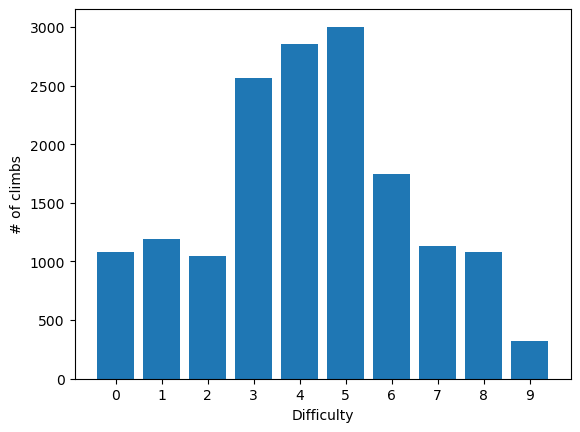

In [7]:
difficulty_distribution = [(key, len(matrix_diff_dict[key])) for key in list(matrix_diff_dict.keys())]
print(difficulty_distribution)

plt.bar(list(matrix_diff_dict.keys()),[len(matrix_diff_dict[key]) for key in list(matrix_diff_dict.keys())])
plt.xlabel('Difficulty')
plt.ylabel('# of climbs')
plt.xticks(list(matrix_diff_dict.keys()), list(matrix_diff_dict.keys()))
plt.show()

In [8]:
def get_batch(data, batch_size, block_size):
    """
    Parameters:
        `data` - a list of tuples of 36x35 tensor (matrix climb) and integer difficulty
        `block_size` - the length of each sequence
        `batch_size` - the number of sequences in the batch

    Returns: A tuple of PyTorch tensors (x, t), where
        `x` - represents the input matrices, with shape (batch_size, block_size, seq_length=35)
        `y` - represents the target output matrices, with shape (batch_size, block_size, seq_length=35)
    """
    batch_ix = torch.randint(len(data) - batch_size, (1,))
    x = []
    t = []
    for i, tup in enumerate(data[batch_ix[0]:batch_ix[0]+batch_size]):
        x.append(tup[0][0:block_size, :])
        t.append(tup[0][1:block_size+1, :])
    return torch.stack(x), torch.stack(t)

def one_hot_encode(matrices, hold_dict=hold_dict):
    """
    Parameters:
        matrices is a batch_size x block_size x 35 tensor
        hold_dict is a dictionary of hold mappings
        
    Returns: A batch_size x (block_size * 35) x 5 tensor
    """
    one_hot_climbs = torch.nn.functional.one_hot(matrices.long(),num_classes=len(hold_dict))
    return one_hot_climbs.reshape(matrices.shape[0], matrices.shape[1]*matrices.shape[2], len(hold_dict))

#test_one_hot = one_hot_encode(matrix_climb_targets, hold_dict)
x,t = get_batch(train_data, 20, 5)
print(x.shape)
print(t.shape)

torch.Size([20, 5, 35])
torch.Size([20, 5, 35])


In [9]:
class BoardRNN(torch.nn.Module):
    def __init__(self, hidden_size=256, num_layers=1, hold_dict = hold_dict):
        super(BoardRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.hold_dict = hold_dict
        
        self.LSTM = torch.nn.LSTM(input_size=len(list(self.hold_dict.values())), 
                                  hidden_size=self.hidden_size,
                                  num_layers=self.num_layers, 
                                  batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, len(list(self.hold_dict.values())))

    # X should come in of size (batch_size, (block_size * 36), len(hold_dict.keys()=5))
    def forward(self, X):
        batch_size, seq_len, _ = X.size()
        lstm_out, _ = self.LSTM(X) #(batch_size, (block_size * 35), hidden_size)

        return self.fc(lstm_out) #should be of shape (batch_size, (block_size * 35), 5)
    
    def generate(self, climb_matrix, next_x_rows=5):
        self.eval()
        prediction = self.forward(one_hot_encode(torch.unsqueeze(climb_matrix,0)).float())
        prediction_clean = torch.squeeze(torch.argmax(prediction, dim=-1),0).reshape(climb_matrix.shape)
#         print(torch.eq(prediction[]))
#         print(prediction.shape)
#         print(climb_matrix.shape)
        return prediction, prediction_clean

tensor([[1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],


tensor([[1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],


tensor([[0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],


KeyboardInterrupt: 

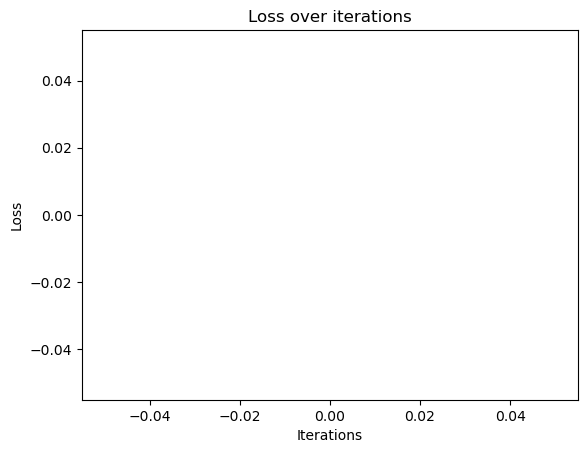

In [22]:
def train_model(model,
                train_data,
                val_data,
                learning_rate=0.005,
                batch_size=100,
                num_epochs=20,
                plot_every=20):
    """
    Train the PyTorch model `model` using the training data `train_data` and the
    corresponding hyperparameters. Report training loss, training accuracy, and
    validation accuracy every `plot_every` iterations.
    """
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True) # reshuffle minibatches every epoch
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i in range(0, len(train_data), batch_size):
                matrices, targets = get_batch(train_data, batch_size, 5) #(batch_size, block_size, 35)
#                 attn_mask = ((matrices < 1))
#                 matrices.masked_fill_(attn_mask, -1e9)
                
                encoded_matrices = one_hot_encode(matrices, hold_dict)
                print(encoded_matrices[0])
                z = model(encoded_matrices.float()) #(batch_size, (block_size * 35), len(hold_dict.keys()))
                
                y = torch.softmax(z.transpose(-1, -2), dim=-1)

                loss = criterion(y,targets.reshape((batch_size, 5*35)).long())
                
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    train_loss.append(float(loss))
#                     ta = accuracy(model, train_data)
#                     train_acc.append(ta)
#                     va = accuracy(model, val_data)
#                     val_acc.append(va)
                    print(iter_count, "Loss:", float(loss))#, "Train Acc:", ta, "Val Acc:", va)
    finally:
        plt.figure()
        plt.plot(iters[:len(train_loss)], train_loss)
        plt.title("Loss over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")

#         plt.figure()
#         plt.plot(iters[:len(train_acc)], train_acc)
#         plt.plot(iters[:len(val_acc)], val_acc)
#         plt.title("Accuracy over iterations")
#         plt.xlabel("Iterations")
#         plt.ylabel("Accuracy")
#         plt.legend(["Train", "Validation"])

model = BoardRNN()
train_model(model, train_data, val_data, learning_rate=0.001
            ,batch_size=100, num_epochs=5)

In [16]:
def plot_matrix(matrix_tuple):
        matrix_tensor = matrix_tuple[0]
        matrix_difficulty = matrix_tuple[1]
        fig, axes = plt.subplots(1, 1, figsize=(36,35))
        
        axes.set_title(matrix_difficulty, fontsize=16)
        axes.matshow(matrix_tensor, cmap=placements._default_board_cmap)
        
        fig.set_size_inches((5, 5))
        plt.subplots_adjust(hspace=0.25, wspace=0.0)
        plt.show()

In [23]:
def sequence_mask(lengths, maxlen=None, dtype=torch.bool):
        if maxlen is None:
            maxlen = lengths.max()
        row_vector = torch.arange(0, maxlen, 1)
        matrix = torch.unsqueeze(lengths, dim=-1)
        mask = row_vector < matrix

        mask.type(dtype)
        return mask

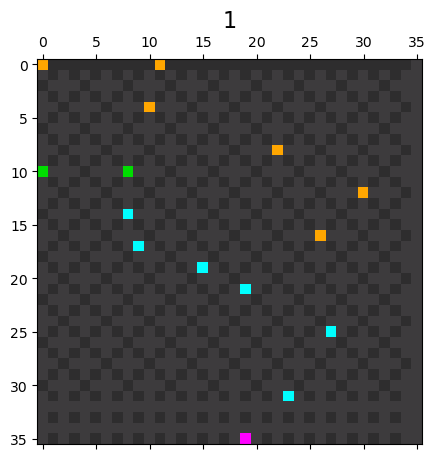

tensor([[    0.1823,     0.4853,     0.0820,     0.0870,     0.0809,     0.0826],
        [    0.6129,     0.2563,     0.0355,     0.0246,     0.0523,     0.0184],
        [    0.1300,     0.8628,     0.0016,     0.0018,     0.0025,     0.0012],
        [    0.9795,     0.0118,     0.0019,     0.0006,     0.0060,     0.0003],
        [    0.0154,     0.9844,     0.0000,     0.0001,     0.0001,     0.0000],
        [    0.9936,     0.0008,     0.0009,     0.0002,     0.0044,     0.0001],
        [    0.0036,     0.9964,     0.0000,     0.0000,     0.0000,     0.0000],
        [    0.9920,     0.0008,     0.0011,     0.0002,     0.0058,     0.0001],
        [    0.0025,     0.9974,     0.0000,     0.0000,     0.0000,     0.0000],
        [    0.9908,     0.0010,     0.0013,     0.0002,     0.0066,     0.0001],
        [    0.0022,     0.9978,     0.0000,     0.0000,     0.0000,     0.0000],
        [    0.9895,     0.0012,     0.0015,     0.0003,     0.0074,     0.0001],
        [    0.0

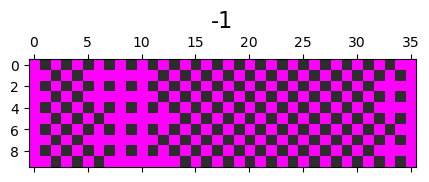

TypeError: sequence_mask() missing 1 required positional argument: 'lengths'

In [24]:
torch.set_printoptions(threshold=2500,precision=4, sci_mode=False)
test_matrix = matrix_climb_targets[3][0][:10, :]
plot_matrix(matrix_climb_targets[3])
generated = model.generate(test_matrix)
#print(generated[0])
softmaxed = torch.squeeze(torch.softmax(generated[0], dim=-1).detach(),0)
print(softmaxed)
# print(generated[1])
plot_matrix((generated[1],-1))

print(sequence_mask(test_matrix))